In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import geojsonio
from datetime import timedelta, date, datetime
import time
import plotly.express as px
import glob as gb
import json
import pytz
from sklearn.metrics import mean_squared_error
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [82]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 15

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE+2)  # fontsize of the figure title

In [2]:
start_time = time.time()

#Initialize an empty dataframe to append daily and hourly resampled data
dailyGridActivity = pd.DataFrame()
hourlyGridActivity = pd.DataFrame()

#Create a list of 62 data file names placed under directory  "dataverse_files" with extension .txt
filenames = gb.glob("dataverse_files/*.txt")

#Set the column names for the data read
col_list = ['gridID', 'timeInterval', 'countryCode', 'smsIn', 'smsOut', 'callIn', 'callOut', 'internet']

#Read each tab separated file into Pandas DataFrame 
for file in filenames:
    read_data = pd.read_csv(file, sep='\t',header=None, names=col_list, parse_dates=True)
    
    #Convert timeInterval column which has Epoch timestamps to UTC and then convert to Milan's local timezone
    read_data['startTime'] = pd.to_datetime(read_data.timeInterval, unit='ms', utc=True).dt.tz_convert('CET').dt.tz_localize(None)
    
    #Drop timeInterval & countryCode columns
    read_data.drop(columns=['timeInterval','countryCode'], inplace=True)
    
    #Groupby gridID and startTime, startTime which is 10 min apart is resampled to daily aggregation 
    read_data_daily = read_data.groupby(['gridID', pd.Grouper(key='startTime', freq='D')]).sum()
    dailyGridActivity = pd.concat([dailyGridActivity,read_data_daily]).groupby(['gridID', 'startTime']).sum()
    
    #Groupby gridID and startTime, startTime which is 10 min apart is resampled to hourly aggregation 
    read_data_hourly = read_data.groupby(['gridID', pd.Grouper(key='startTime', freq='H')]).sum()
    hourlyGridActivity = pd.concat([hourlyGridActivity,read_data_hourly]).groupby(['gridID', 'startTime']).sum()
    
#Get Grid wise total volume of the activities over the 2months
totalGridActivity = dailyGridActivity.groupby('gridID').sum()
    
print('%3.2f s' %(time.time() - start_time))

885.75 s


In [3]:
#Create additional columns hours:hour of the day, weekdayFlag: weekend or weekday information
dailyGridActivity['weekdayFlag'] = dailyGridActivity.index.get_level_values(1)
dailyGridActivity['weekdayFlag'] = dailyGridActivity['weekdayFlag'].dt.weekday

hourlyGridActivity['weekdayFlag'] = hourlyGridActivity.index.get_level_values(1)
hourlyGridActivity['weekdayFlag'] = hourlyGridActivity['weekdayFlag'].dt.weekday

hourlyGridActivity['hours'] = hourlyGridActivity.index.get_level_values(1)
hourlyGridActivity['hours'] = hourlyGridActivity['hours'].dt.hour

dailyGridActivity['sms'] = dailyGridActivity['smsIn'] + dailyGridActivity['smsOut']
dailyGridActivity['call'] = dailyGridActivity['callIn'] + dailyGridActivity['callOut']

hourlyGridActivity['sms'] = hourlyGridActivity['smsIn'] + hourlyGridActivity['smsOut']
hourlyGridActivity['call'] = hourlyGridActivity['callIn'] + hourlyGridActivity['callOut']

totalGridActivity['sms'] = totalGridActivity['smsIn']+totalGridActivity['smsOut']
totalGridActivity['call'] = totalGridActivity['callIn']+totalGridActivity['callOut']

In [4]:
#Three regions of interest
sqid_intr = ['5161','4159','4556']
#Get daily data for the three grids 
daily5161 = dailyGridActivity.loc[5161][['sms','call','internet']]
daily4159 = dailyGridActivity.loc[4159][['sms','call','internet']]
daily4556 = dailyGridActivity.loc[4556][['sms','call','internet']]

daily5161Internet = daily5161[['internet']]
daily4159Internet = daily4159[['internet']]
daily4556Internet = daily4556[['internet']]

#Get hourly data for the three grids 
hourly5161 = hourlyGridActivity.loc[5161]
hourly4159 = hourlyGridActivity.loc[4159]
hourly4556 = hourlyGridActivity.loc[4556]

# Forecasting

In [5]:
#Start and End date for Training
start_date_fort = date(2013, 11, 1)
end_date_fort = date(2013, 12, 15)

#'fort' implies training set for forecasting
daily5161_fort = daily5161.loc[start_date_fort:end_date_fort]
daily4159_fort = daily4159.loc[start_date_fort:end_date_fort]
daily4556_fort = daily4556.loc[start_date_fort:end_date_fort]

hourly5161_fort = hourly5161.loc[start_date_fort:end_date_fort]
hourly4159_fort = hourly4159.loc[start_date_fort:end_date_fort]
hourly4556_fort = hourly4556.loc[start_date_fort:end_date_fort]

#Start and End date for Training
start_date_forte = date(2013, 12, 16)
end_date_forte = date(2013, 12, 22)

#'forte' implies testing set for forecasting
daily5161_forte = daily5161.loc[start_date_forte:end_date_forte]
daily4159_forte = daily4159.loc[start_date_forte:end_date_forte]
daily4556_forte = daily4556.loc[start_date_forte:end_date_forte]

hourly5161_forte = hourly5161.loc[start_date_forte:end_date_forte]
hourly4159_forte = hourly4159.loc[start_date_forte:end_date_forte]
hourly4556_forte = hourly4556.loc[start_date_forte:end_date_forte]

## Grid 5161

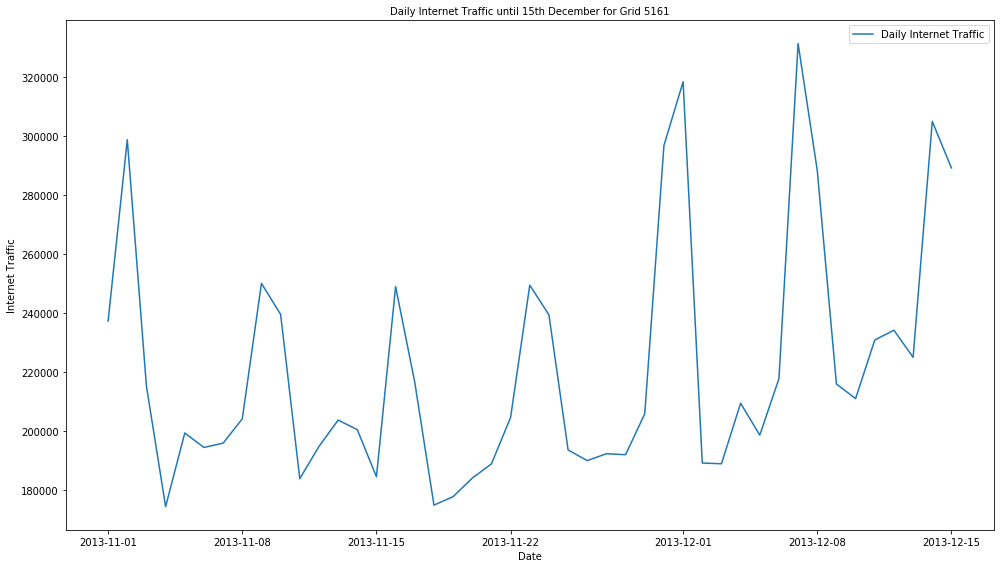

In [83]:
#Time series plot of grid 5161's Daily Internet Activity
daily5161Internet_fort = daily5161_fort[['internet']]

plt.figure(figsize=(14,8))
plt.plot(daily5161Internet_fort.index, daily5161Internet_fort, label='Daily Internet Traffic')
plt.title('Daily Internet Traffic until 15th December for Grid 5161')
plt.xlabel('Date')
plt.ylabel('Internet Traffic')
plt.legend()
plt.tight_layout()
plt.savefig('sav_images/5161_internet_daily.svg',transparent=True)
plt.show()

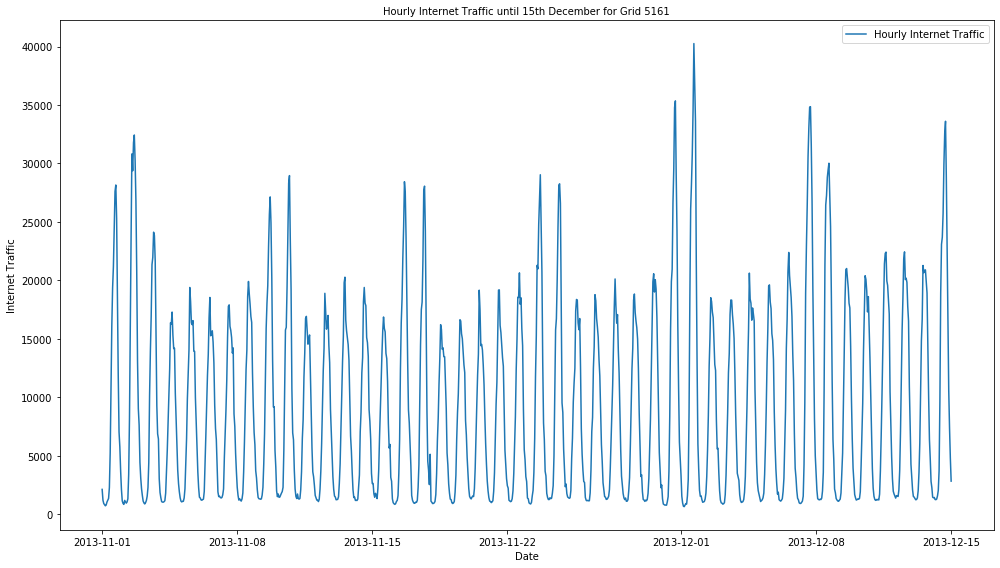

In [84]:
#Time series plot of grid 5161's Hourly Internet Activity
hourly5161Internet_fort = hourly5161_fort[['internet']]

plt.figure(figsize=(14,8))
plt.plot(hourly5161Internet_fort.index, hourly5161Internet_fort, label='Hourly Internet Traffic')
plt.title('Hourly Internet Traffic until 15th December for Grid 5161')
plt.xlabel('Date')
plt.ylabel('Internet Traffic')
plt.legend()
plt.tight_layout()
plt.savefig('sav_images/5161_internet_hourly.svg',transparent=True)
plt.show()

### Time Series decomposition

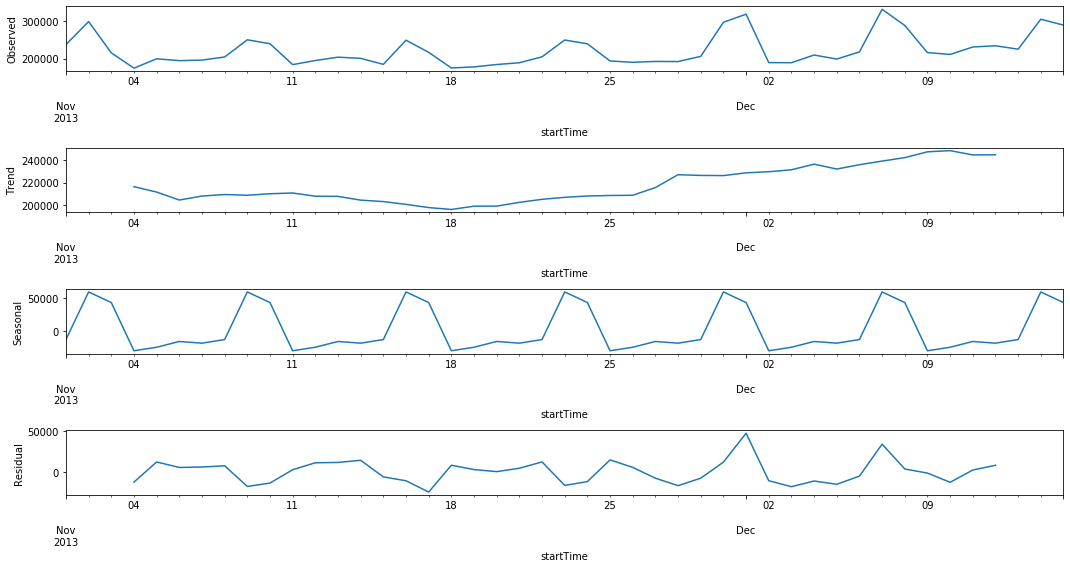

In [115]:
decomp_results = seasonal_decompose(daily5161Internet_fort)

# Plot decomposed data
res = decomp_results
fig, axes = plt.subplots(4,1,figsize=(15,8))
res.observed.plot(ax=axes[0],legend=False)
axes[0].set_ylabel('Observed')
res.trend.plot(ax=axes[1],legend=False)
axes[1].set_ylabel('Trend')
res.seasonal.plot(ax=axes[2],legend=False)
axes[2].set_ylabel('Seasonal')
res.resid.plot(ax=axes[3],legend=False)
axes[3].set_ylabel('Residual')
plt.tight_layout()
plt.savefig('sav_images/5161_ts_decomp.svg',transparent=True)
plt.show()

### Augmented Dicky fuller test to check for stationarity in trend

In [116]:
results = adfuller(daily5161Internet_fort.internet)
pval = results[1]
print("P-Value:",pval)

P-Value: 0.9753410131544685


In [117]:
daily5161Internet_fort_diff = daily5161Internet_fort.diff().fillna(0)
results = adfuller(daily5161Internet_fort_diff.internet)
pval = results[1]
print("P-Value after 1st differentiation:",pval)

P-Value after 1st differentiation: 8.49853716928619e-17


Performing stepwise search to minimize aic
Fit ARIMA(0,1,0)x(0,0,0,7) [intercept=True]; AIC=1069.141, BIC=1072.709, Time=0.007 seconds
Fit ARIMA(1,1,0)x(1,0,0,7) [intercept=True]; AIC=1059.131, BIC=1066.268, Time=0.149 seconds
Fit ARIMA(0,1,1)x(0,0,1,7) [intercept=True]; AIC=1060.230, BIC=1067.367, Time=0.052 seconds
Fit ARIMA(0,1,0)x(0,0,0,7) [intercept=False]; AIC=1067.184, BIC=1068.968, Time=0.005 seconds
Fit ARIMA(1,1,0)x(0,0,0,7) [intercept=True]; AIC=1070.844, BIC=1076.197, Time=0.012 seconds
Fit ARIMA(1,1,0)x(2,0,0,7) [intercept=True]; AIC=1060.572, BIC=1069.493, Time=0.103 seconds
Fit ARIMA(1,1,0)x(1,0,1,7) [intercept=True]; AIC=1059.126, BIC=1068.047, Time=0.137 seconds
Fit ARIMA(1,1,0)x(0,0,1,7) [intercept=True]; AIC=1061.153, BIC=1068.290, Time=0.055 seconds
Fit ARIMA(1,1,0)x(2,0,1,7) [intercept=True]; AIC=1060.909, BIC=1071.614, Time=0.337 seconds
Fit ARIMA(1,1,0)x(1,0,2,7) [intercept=True]; AIC=1060.841, BIC=1071.547, Time=0.202 seconds
Fit ARIMA(1,1,0)x(0,0,2,7) [intercep

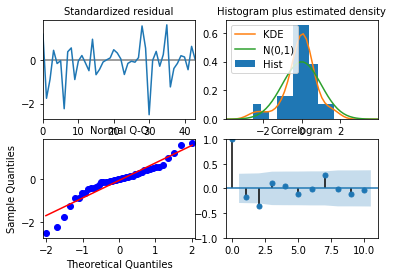

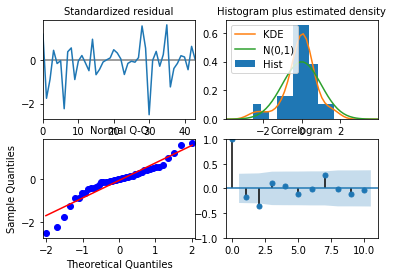

In [118]:
results = pm.auto_arima(daily5161Internet_fort, start_p=0, max_p=12, d=1,max_d=5, start_q=0, max_q=5, start_P=0, max_P=12, 
                        D=0, max_D=5, start_Q=0, max_Q=5, seasonal=True, m=7,
                        trace=True, error_action='ignore',suppress_warnings=True)
print(results.summary())
results.plot_diagnostics()

In [119]:
#Fit the model on the original dataset
model = SARIMAX(daily5161Internet_fort, order=(0,1,0), seasonal_order=(1,0,0,7))
result = model.fit()

C:\Users\pjsudharshan\anaconda3\envs\testing\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\pjsudharshan\anaconda3\envs\testing\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [120]:
#Forecast daily internet volume values for December 16 to 22
forecast_object = result.get_forecast(steps=7)
mean = forecast_object.predicted_mean
conf_int = forecast_object.conf_int()

In [121]:
#Defining daily5161Internet for testing set
daily5161Internet_forte = daily5161_forte[['internet']]

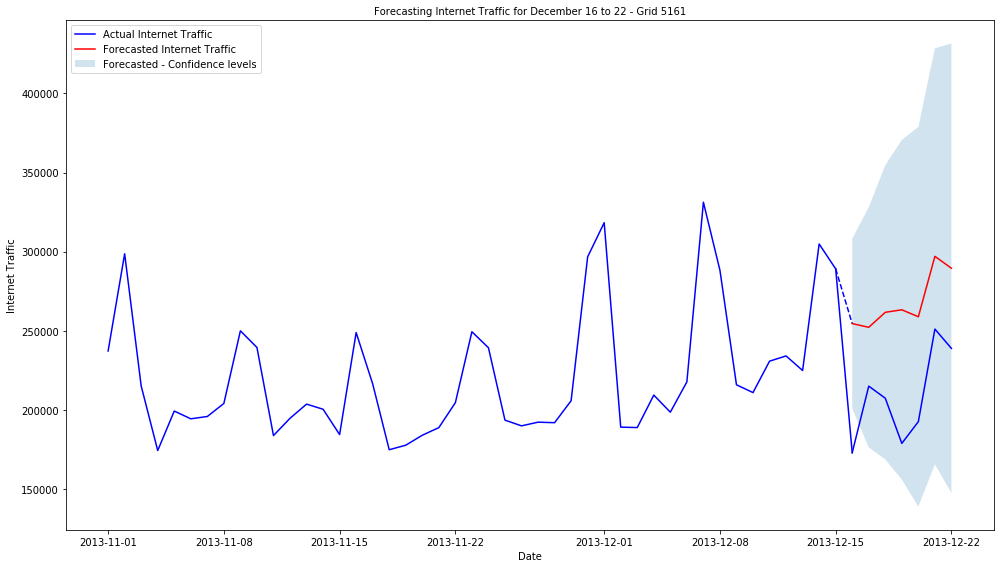

In [122]:
#Superposed time series plot

plt.figure(figsize=(14,8))
plt.plot(daily5161Internet_fort.index, daily5161Internet_fort, 'b', label='Actual Internet Traffic')
plt.plot(daily5161Internet_forte.index, daily5161Internet_forte, 'b')

# Plot the prediction means as line
plt.plot([daily5161Internet_fort.index[-1],mean.index[0]], [daily5161Internet_fort.values[-1],mean[0]], 'b--')
plt.plot([daily5161Internet_fort.index[-1],daily5161Internet_forte.index[0]], \
         [daily5161Internet_fort.values[-1],daily5161Internet_forte.values[0]], 'b')

plt.plot(mean.index, mean, label='Forecasted Internet Traffic', color='r')

plt.fill_between(mean.index, conf_int.iloc[:,0], conf_int.iloc[:,1], alpha=0.2, label='Forecasted - Confidence levels')
plt.legend(loc='upper left')
plt.title('Forecasting Internet Traffic for December 16 to 22 - Grid 5161')
plt.xlabel('Date')
plt.ylabel('Internet Traffic')
plt.tight_layout()
plt.savefig('sav_images/5161_internet_for.svg',transparent=True)
plt.show()
plt.show()

In [123]:
#Function to calculate MAE and MAPE
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [124]:
#Forcasting Error for the above grid
mae_error = mean_absolute_error(daily5161Internet_forte.internet,mean)
mape_error = mean_absolute_percentage_error(daily5161Internet_forte.internet,mean)
print("Mean Absolute Error (MAE) = {:.3f}".format(mae_error))
print("Mean Absolute Percentage Error (MAPE) = {:.3f}%".format(mape_error))
print("Accuracy = {:.3f}%".format(100-mape_error))

Mean Absolute Error (MAE) = 60053.980
Mean Absolute Percentage Error (MAPE) = 30.254%
Accuracy = 69.746%


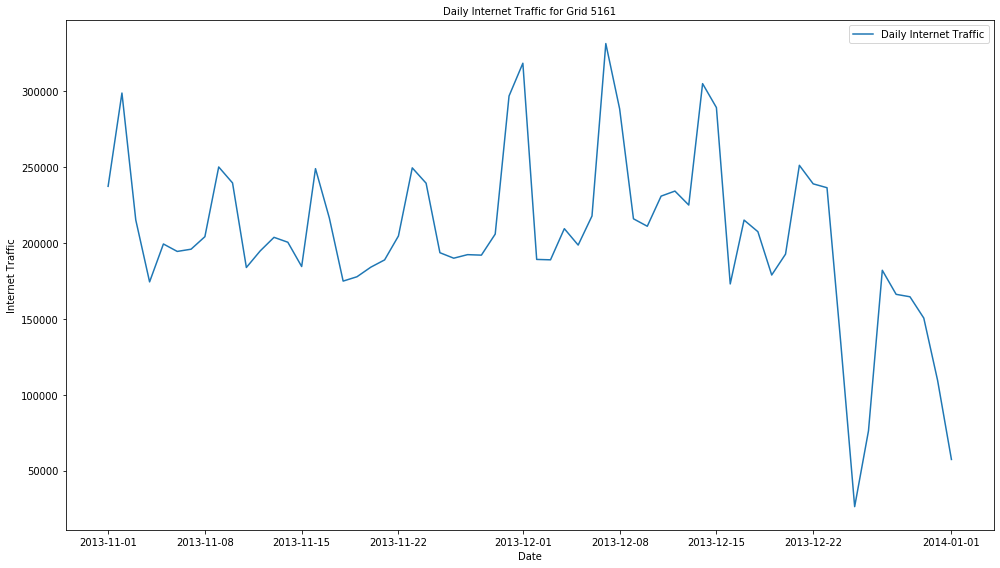

In [125]:
#Time series plot of grid 5161's Daily Internet Activity including December 16 to 22
plt.figure(figsize=(14,8))
plt.plot(daily5161Internet.index, daily5161Internet, label='Daily Internet Traffic')
plt.title('Daily Internet Traffic for Grid 5161')
plt.xlabel('Date')
plt.ylabel('Internet Traffic')
plt.legend()
plt.tight_layout()
plt.savefig('sav_images/5161_internet_daily_all.svg',transparent=True)
plt.show()

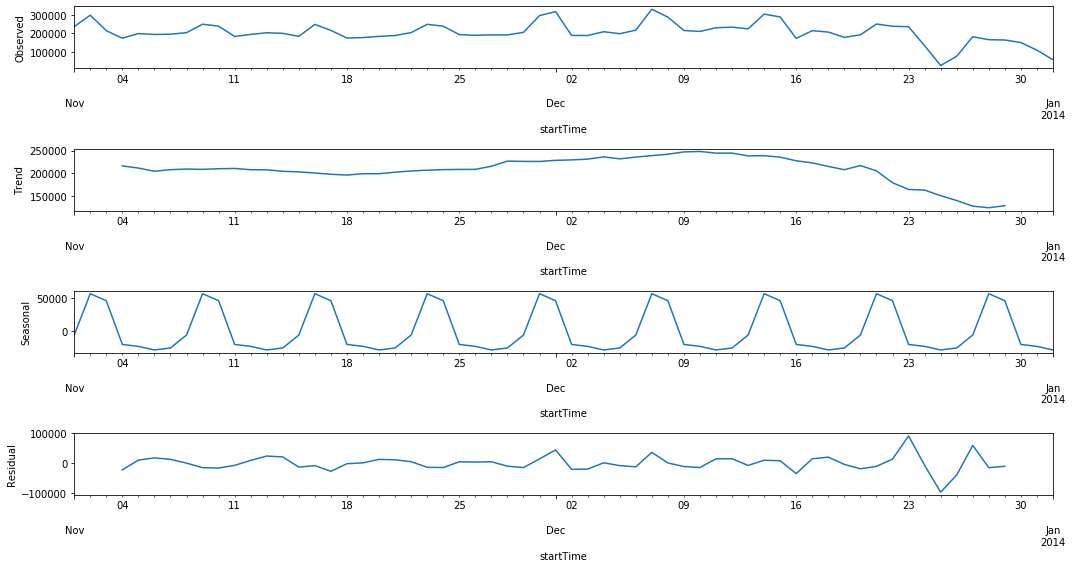

In [126]:
decomp_results = seasonal_decompose(daily5161Internet, period=7)

# Plot decomposed data
res = decomp_results
fig, axes = plt.subplots(4,1,figsize=(15,8))
res.observed.plot(ax=axes[0],legend=False)
axes[0].set_ylabel('Observed')
res.trend.plot(ax=axes[1],legend=False)
axes[1].set_ylabel('Trend')
res.seasonal.plot(ax=axes[2],legend=False)
axes[2].set_ylabel('Seasonal')
res.resid.plot(ax=axes[3],legend=False)
axes[3].set_ylabel('Residual')
fig.tight_layout()
plt.savefig('sav_images/5161_ts_decomp_all.svg',transparent=True)
plt.show()

### End of Grid 5161
### -------------------------

## Grid 4159

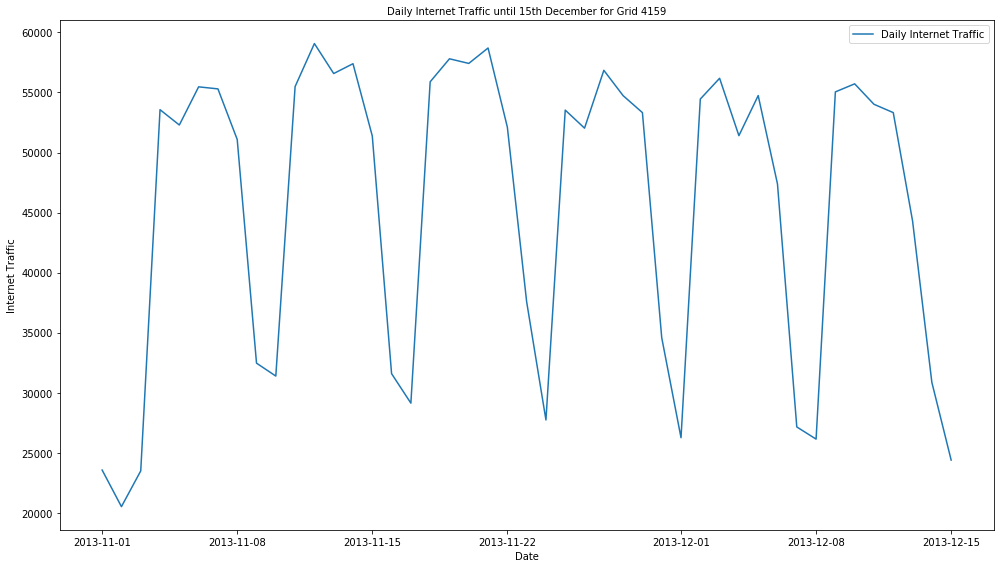

In [127]:
#Time series plot of grid 4159's Daily Internet Activity
daily4159Internet_fort = daily4159_fort[['internet']]

plt.figure(figsize=(14,8))
plt.plot(daily4159Internet_fort.index, daily4159Internet_fort, label='Daily Internet Traffic')
plt.title('Daily Internet Traffic until 15th December for Grid 4159')
plt.xlabel('Date')
plt.ylabel('Internet Traffic')
plt.legend()
plt.tight_layout()
plt.savefig('sav_images/4159_internet_daily.svg',transparent=True)
plt.show()

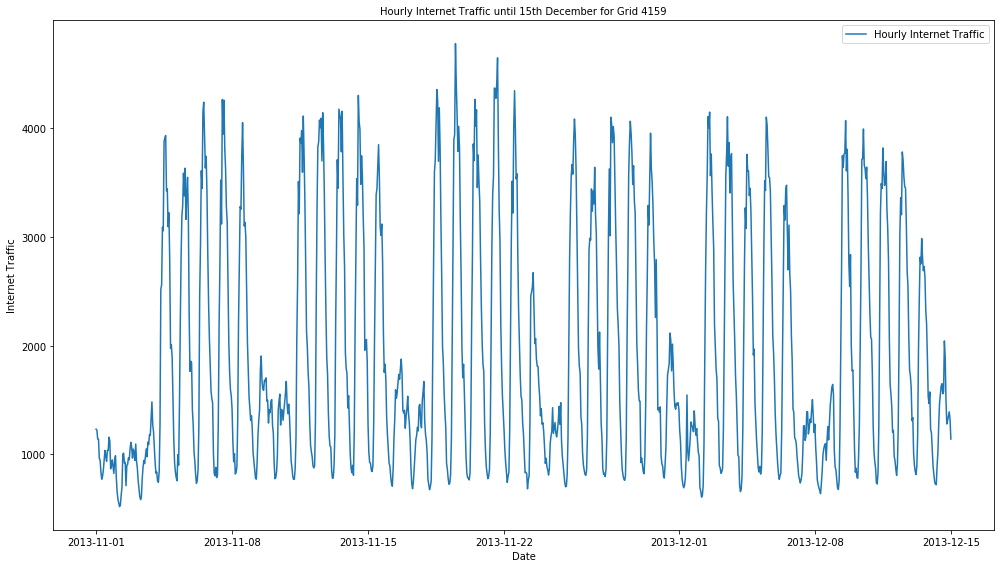

In [128]:
#Time series plot of grid 4159's Hourly Internet Activity
hourly4159Internet_fort = hourly4159_fort[['internet']]

plt.figure(figsize=(14,8))
plt.plot(hourly4159Internet_fort.index, hourly4159Internet_fort, label='Hourly Internet Traffic')
plt.title('Hourly Internet Traffic until 15th December for Grid 4159')
plt.xlabel('Date')
plt.ylabel('Internet Traffic')
plt.legend()
plt.tight_layout()
plt.savefig('sav_images/4159_internet_hourly.svg',transparent=True)
plt.show()

### Time Series decomposition

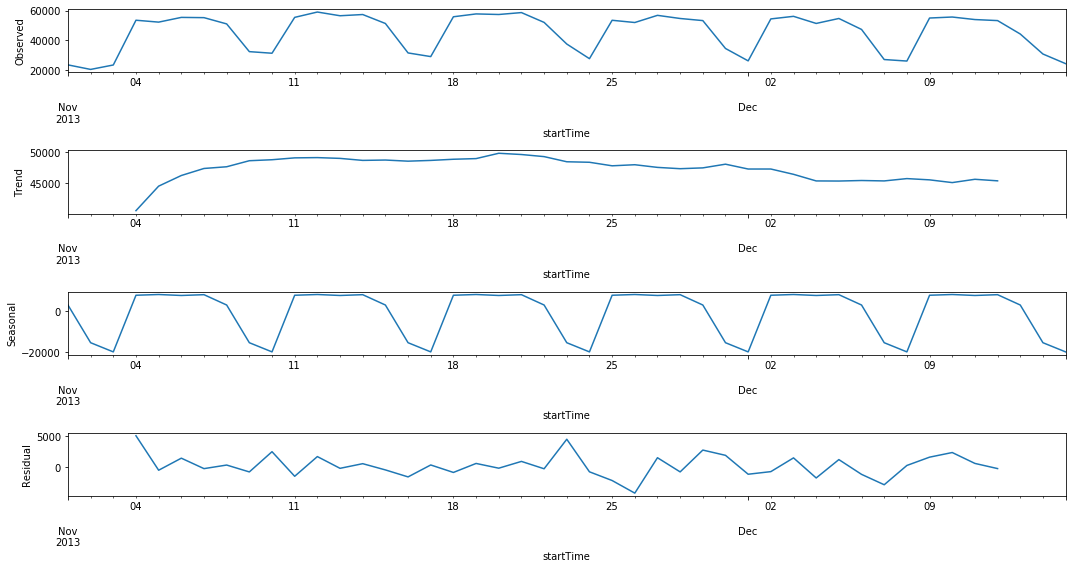

In [130]:
decomp_results = seasonal_decompose(daily4159Internet_fort)

# Plot decomposed data
res = decomp_results
fig, axes = plt.subplots(4,1,figsize=(15,8))
res.observed.plot(ax=axes[0],legend=False)
axes[0].set_ylabel('Observed')
res.trend.plot(ax=axes[1],legend=False)
axes[1].set_ylabel('Trend')
res.seasonal.plot(ax=axes[2],legend=False)
axes[2].set_ylabel('Seasonal')
res.resid.plot(ax=axes[3],legend=False)
axes[3].set_ylabel('Residual')
fig.tight_layout()
plt.savefig('sav_images/4159_ts_decomp.svg',transparent=True)
plt.show()

### Augmented Dicky fuller test to check for stationarity in trend

In [131]:
results = adfuller(daily4159Internet_fort.internet)
pval = results[1]
print("P-Value:",pval)

P-Value: 0.8340581268111333


In [132]:
daily4159Internet_fort_diff = daily4159Internet_fort.diff().fillna(0)
results = adfuller(daily4159Internet_fort_diff.internet)
pval = results[1]
print("P-Value after 1st differentiation:",pval)

P-Value after 1st differentiation: 3.61006483272652e-17


Performing stepwise search to minimize aic
Fit ARIMA(0,1,0)x(0,0,0,7) [intercept=True]; AIC=959.599, BIC=963.168, Time=0.008 seconds
Fit ARIMA(1,1,0)x(1,0,0,7) [intercept=True]; AIC=909.750, BIC=916.887, Time=0.210 seconds
Fit ARIMA(0,1,1)x(0,0,1,7) [intercept=True]; AIC=943.438, BIC=950.575, Time=0.074 seconds
Fit ARIMA(0,1,0)x(0,0,0,7) [intercept=False]; AIC=957.611, BIC=959.395, Time=0.004 seconds
Fit ARIMA(1,1,0)x(0,0,0,7) [intercept=True]; AIC=961.393, BIC=966.745, Time=0.012 seconds
Fit ARIMA(1,1,0)x(2,0,0,7) [intercept=True]; AIC=910.251, BIC=919.172, Time=0.634 seconds
Fit ARIMA(1,1,0)x(1,0,1,7) [intercept=True]; AIC=910.720, BIC=919.641, Time=0.411 seconds
Fit ARIMA(1,1,0)x(0,0,1,7) [intercept=True]; AIC=945.055, BIC=952.191, Time=0.062 seconds
Fit ARIMA(1,1,0)x(2,0,1,7) [intercept=True]; AIC=913.984, BIC=924.689, Time=0.430 seconds
Near non-invertible roots for order (1, 1, 0)(2, 0, 1, 7); setting score to inf (at least one inverse root too close to the border of the unit cir

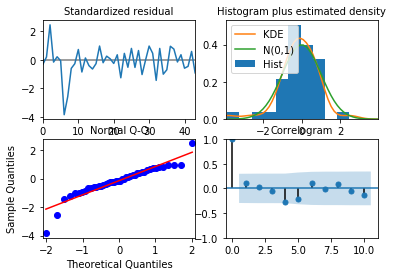

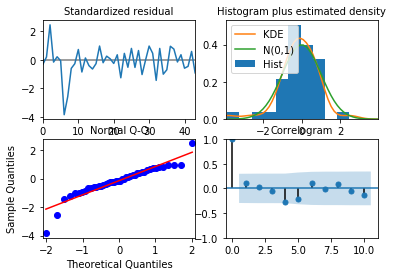

In [133]:
results = pm.auto_arima(daily4159Internet_fort, start_p=0, max_p=12, d=1,max_d=5, start_q=0, max_q=5, start_P=0, max_P=12, 
                        D=0, max_D=5, start_Q=0, max_Q=5, seasonal=True, m=7,
                        trace=True, error_action='ignore',suppress_warnings=True)
print(results.summary())
results.plot_diagnostics()

In [134]:
#Fit the model on the original dataset
model = SARIMAX(daily4159Internet_fort, order=(0,1,0), seasonal_order=(1,0,0,7))
result = model.fit()

C:\Users\pjsudharshan\anaconda3\envs\testing\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\pjsudharshan\anaconda3\envs\testing\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [135]:
#Forecast daily internet volume values for December 16 to 22
forecast_object = result.get_forecast(steps=7)
mean = forecast_object.predicted_mean
conf_int = forecast_object.conf_int()

In [136]:
#Defining daily4159Internet for testing set
daily4159Internet_forte = daily4159_forte[['internet']]

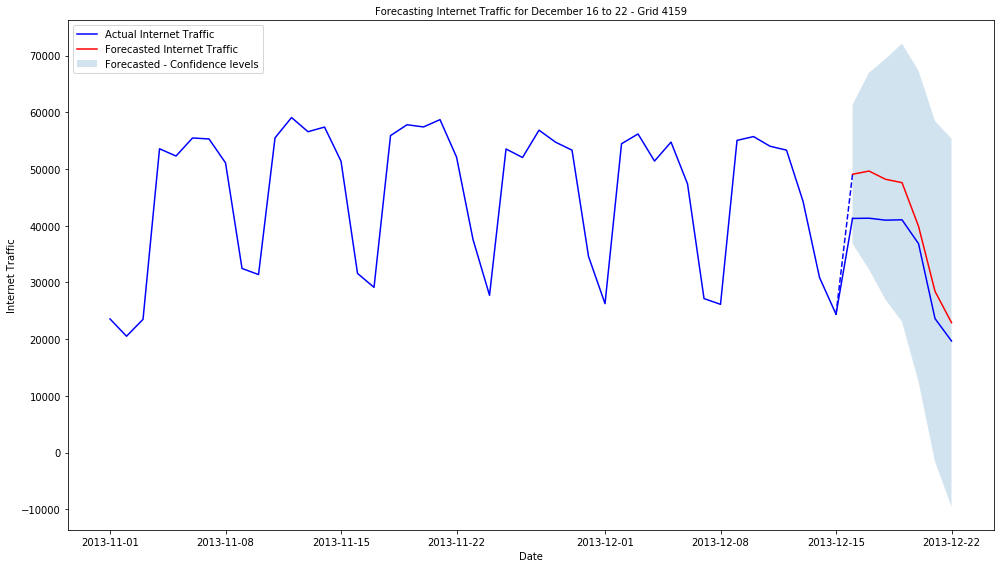

In [137]:
#Superposed time series plot

plt.figure(figsize=(14,8))
plt.plot(daily4159Internet_fort.index, daily4159Internet_fort, 'b', label='Actual Internet Traffic')
plt.plot(daily4159Internet_forte.index, daily4159Internet_forte, 'b')

# Plot the prediction means as line
plt.plot([daily4159Internet_fort.index[-1],mean.index[0]], [daily4159Internet_fort.values[-1],mean[0]], 'b--')
plt.plot([daily4159Internet_fort.index[-1],daily4159Internet_forte.index[0]], \
         [daily4159Internet_fort.values[-1],daily4159Internet_forte.values[0]], 'b')

plt.plot(mean.index, mean, label='Forecasted Internet Traffic', color='r')

plt.fill_between(mean.index, conf_int.iloc[:,0], conf_int.iloc[:,1], alpha=0.2, label='Forecasted - Confidence levels')
plt.legend(loc='upper left')
plt.title('Forecasting Internet Traffic for December 16 to 22 - Grid 4159')
plt.xlabel('Date')
plt.ylabel('Internet Traffic')
plt.tight_layout()
plt.savefig('sav_images/4159_internet_for.svg',transparent=True)
plt.show()
plt.show()

In [138]:
#Function to calculate MAE and MAPE
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [139]:
#Forcasting Error for the above grid
mae_error = mean_absolute_error(daily4159Internet_forte.internet,mean)
mape_error = mean_absolute_percentage_error(daily4159Internet_forte.internet,mean)
print("Mean Absolute Error (MAE) = {:.3f}".format(mae_error))
print("Mean Absolute Percentage Error (MAPE) = {:.3f}%".format(mape_error))
print("Accuracy = {:.3f}%".format(100-mape_error))

Mean Absolute Error (MAE) = 5853.548
Mean Absolute Percentage Error (MAPE) = 16.809%
Accuracy = 83.191%


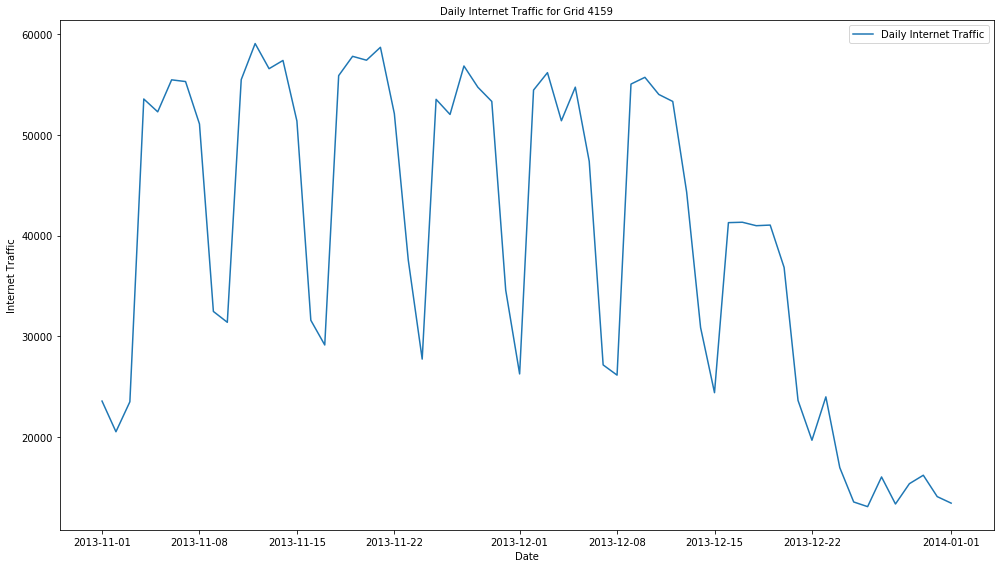

In [140]:
#Time series plot of grid 4159's Daily Internet Activity including December 16 to 22
plt.figure(figsize=(14,8))
plt.plot(daily4159Internet.index, daily4159Internet, label='Daily Internet Traffic')
plt.title('Daily Internet Traffic for Grid 4159')
plt.xlabel('Date')
plt.ylabel('Internet Traffic')
plt.legend()
plt.tight_layout()
plt.savefig('sav_images/4159_internet_daily_all.svg',transparent=True)
plt.show()

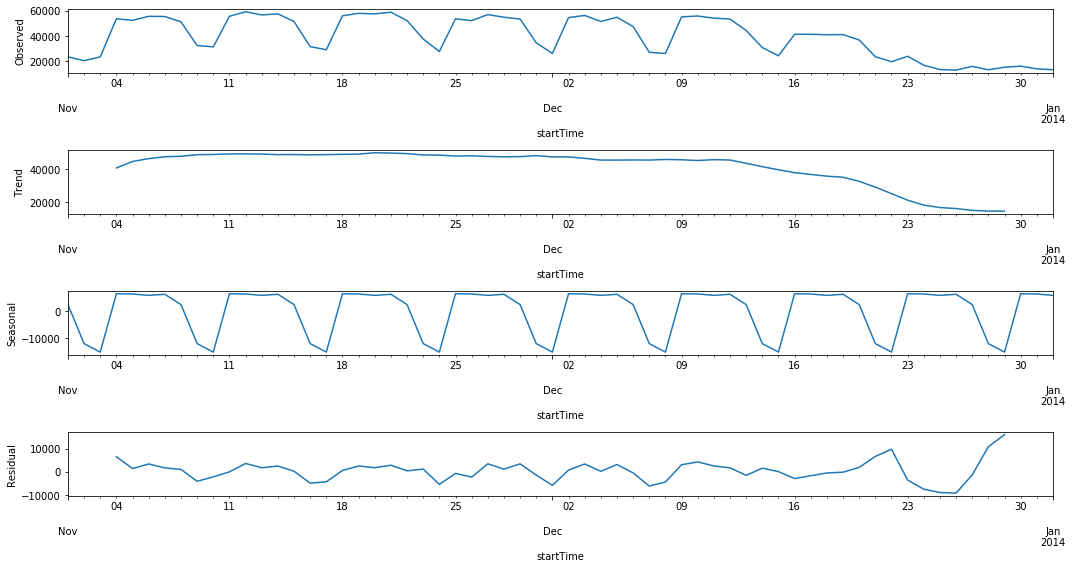

In [141]:
decomp_results = seasonal_decompose(daily4159Internet)

# Plot decomposed data
res = decomp_results
fig, axes = plt.subplots(4,1,figsize=(15,8))
res.observed.plot(ax=axes[0],legend=False)
axes[0].set_ylabel('Observed')
res.trend.plot(ax=axes[1],legend=False)
axes[1].set_ylabel('Trend')
res.seasonal.plot(ax=axes[2],legend=False)
axes[2].set_ylabel('Seasonal')
res.resid.plot(ax=axes[3],legend=False)
axes[3].set_ylabel('Residual')
plt.tight_layout()
plt.savefig('sav_images/4159_ts_decomp_all.svg',transparent=True)
plt.show()

### End of Grid 4159
### -------------------------

## Grid 4556

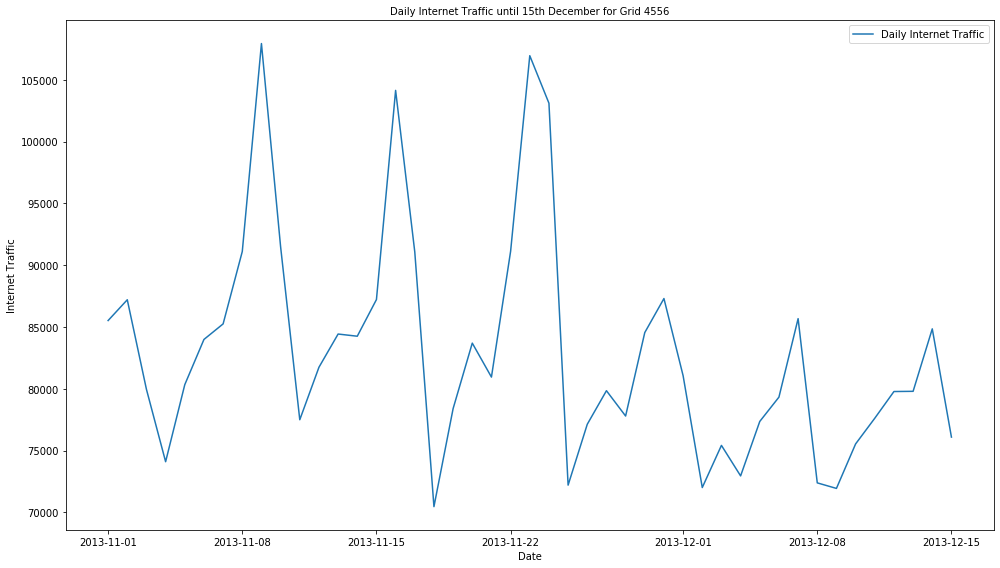

In [158]:
#Time series plot of grid 4556's Daily Internet Activity
daily4556Internet_fort = daily4556_fort[['internet']]

plt.figure(figsize=(14,8))
plt.plot(daily4556Internet_fort.index, daily4556Internet_fort, label='Daily Internet Traffic')
plt.title('Daily Internet Traffic until 15th December for Grid 4556')
plt.xlabel('Date')
plt.ylabel('Internet Traffic')
plt.legend()
plt.tight_layout()
plt.savefig('sav_images/4556_internet_daily.svg',transparent=True)
plt.show()

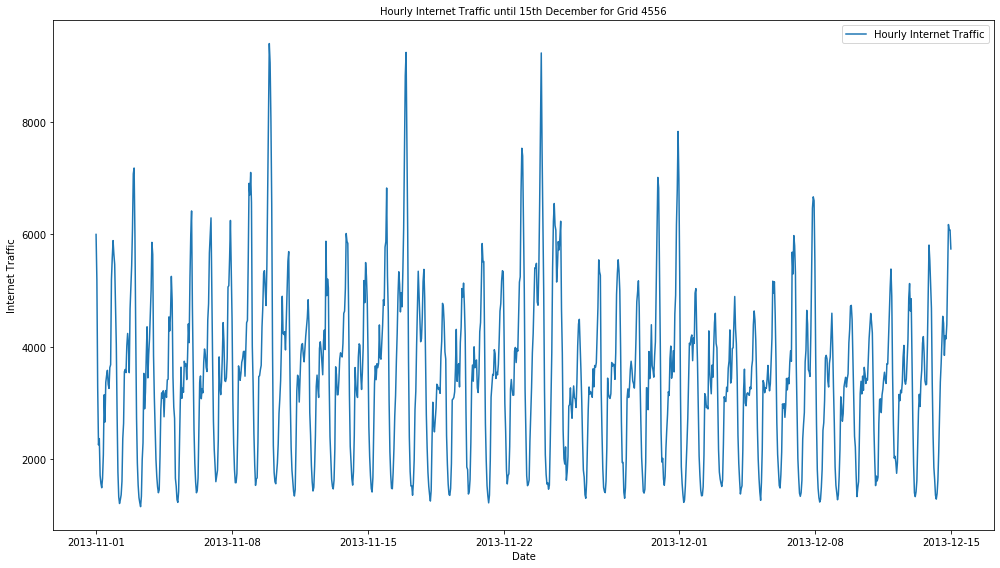

In [159]:
#Time series plot of grid 4556's Hourly Internet Activity
hourly4556Internet_fort = hourly4556_fort[['internet']]

plt.figure(figsize=(14,8))
plt.plot(hourly4556Internet_fort.index, hourly4556Internet_fort, label='Hourly Internet Traffic')
plt.title('Hourly Internet Traffic until 15th December for Grid 4556')
plt.xlabel('Date')
plt.ylabel('Internet Traffic')
plt.legend()
plt.tight_layout()
plt.savefig('sav_images/4556_internet_hourly.svg',transparent=True)
plt.show()

### Time Series decomposition

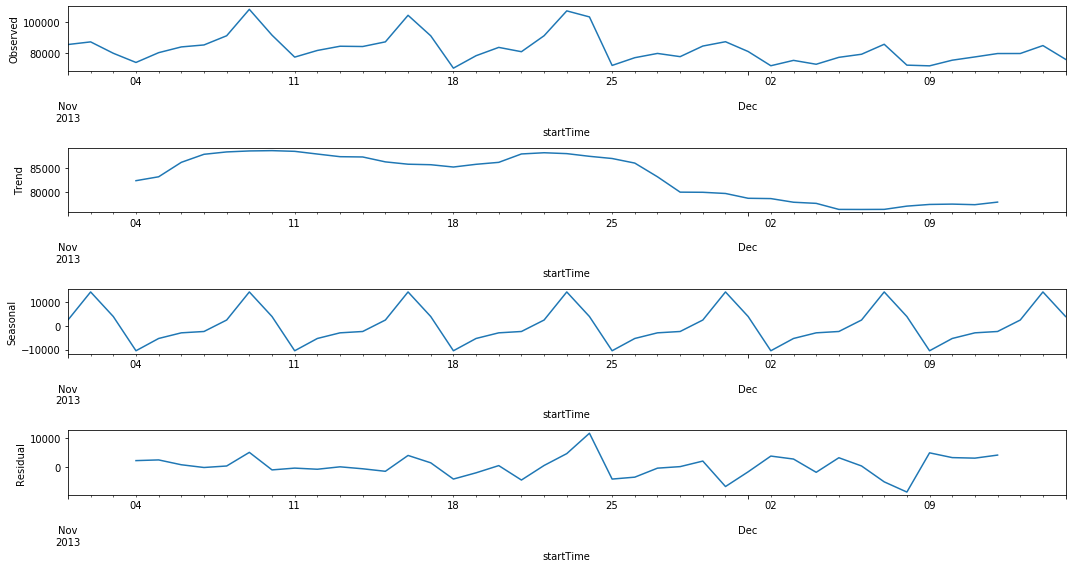

In [160]:
decomp_results = seasonal_decompose(daily4556Internet_fort)

# Plot decomposed data
res = decomp_results
fig, axes = plt.subplots(4,1,figsize=(15,8))
res.observed.plot(ax=axes[0],legend=False)
axes[0].set_ylabel('Observed')
res.trend.plot(ax=axes[1],legend=False)
axes[1].set_ylabel('Trend')
res.seasonal.plot(ax=axes[2],legend=False)
axes[2].set_ylabel('Seasonal')
res.resid.plot(ax=axes[3],legend=False)
axes[3].set_ylabel('Residual')
fig.tight_layout()
plt.savefig('sav_images/4556_ts_decomp.svg',transparent=True)
plt.show()

### Augmented Dicky fuller test to check for stationarity in trend

In [161]:
results = adfuller(daily4556Internet_fort.internet)
pval = results[1]
print("P-Value:",pval)

P-Value: 0.7818093153614623


In [162]:
daily4556Internet_fort_diff = daily4556Internet_fort.diff().fillna(0)
results = adfuller(daily4556Internet_fort_diff.internet)
pval = results[1]
print("P-Value after 1st differentiation:",pval)

P-Value after 1st differentiation: 0.027902935224595544


Performing stepwise search to minimize aic
Fit ARIMA(0,1,0)x(0,0,0,7) [intercept=True]; AIC=933.566, BIC=937.134, Time=0.008 seconds
Fit ARIMA(1,1,0)x(1,0,0,7) [intercept=True]; AIC=926.157, BIC=933.294, Time=0.069 seconds
Fit ARIMA(0,1,1)x(0,0,1,7) [intercept=True]; AIC=928.293, BIC=935.429, Time=0.070 seconds
Fit ARIMA(0,1,0)x(0,0,0,7) [intercept=False]; AIC=931.600, BIC=933.384, Time=0.005 seconds
Fit ARIMA(1,1,0)x(0,0,0,7) [intercept=True]; AIC=935.565, BIC=940.918, Time=0.011 seconds
Fit ARIMA(1,1,0)x(2,0,0,7) [intercept=True]; AIC=927.492, BIC=936.413, Time=0.110 seconds
Fit ARIMA(1,1,0)x(1,0,1,7) [intercept=True]; AIC=926.097, BIC=935.018, Time=0.118 seconds
Fit ARIMA(1,1,0)x(0,0,1,7) [intercept=True]; AIC=927.761, BIC=934.898, Time=0.070 seconds
Fit ARIMA(1,1,0)x(2,0,1,7) [intercept=True]; AIC=927.879, BIC=938.584, Time=0.269 seconds
Fit ARIMA(1,1,0)x(1,0,2,7) [intercept=True]; AIC=927.814, BIC=938.519, Time=0.208 seconds
Fit ARIMA(1,1,0)x(0,0,2,7) [intercept=True]; AIC=928.825

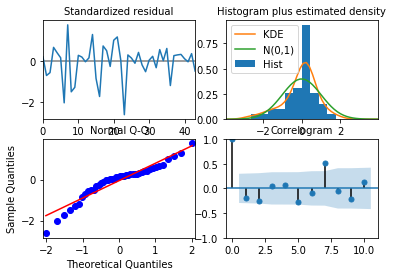

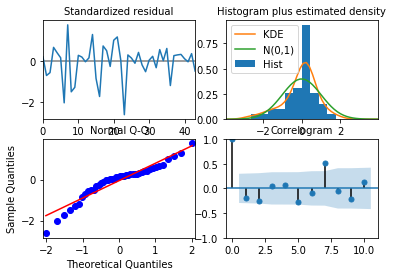

In [163]:
results = pm.auto_arima(daily4556Internet_fort, start_p=0, max_p=12, d=1,max_d=5, start_q=0, max_q=5, start_P=0, max_P=12, 
                        D=0, max_D=5, start_Q=0, max_Q=5, seasonal=True, m=7,
                        trace=True, error_action='ignore',suppress_warnings=True)
print(results.summary())
results.plot_diagnostics()

In [164]:
#Fit the model on the original dataset
model = SARIMAX(daily4556Internet_fort, order=(0,1,0), seasonal_order=(1,0,0,7))
result = model.fit()

C:\Users\pjsudharshan\anaconda3\envs\testing\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\pjsudharshan\anaconda3\envs\testing\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [165]:
#Forecast daily internet volume values for December 16 to 22
forecast_object = result.get_forecast(steps=7)
mean = forecast_object.predicted_mean
conf_int = forecast_object.conf_int()

In [166]:
#Defining daily4556Internet for testing set
daily4556Internet_forte = daily4556_forte[['internet']]

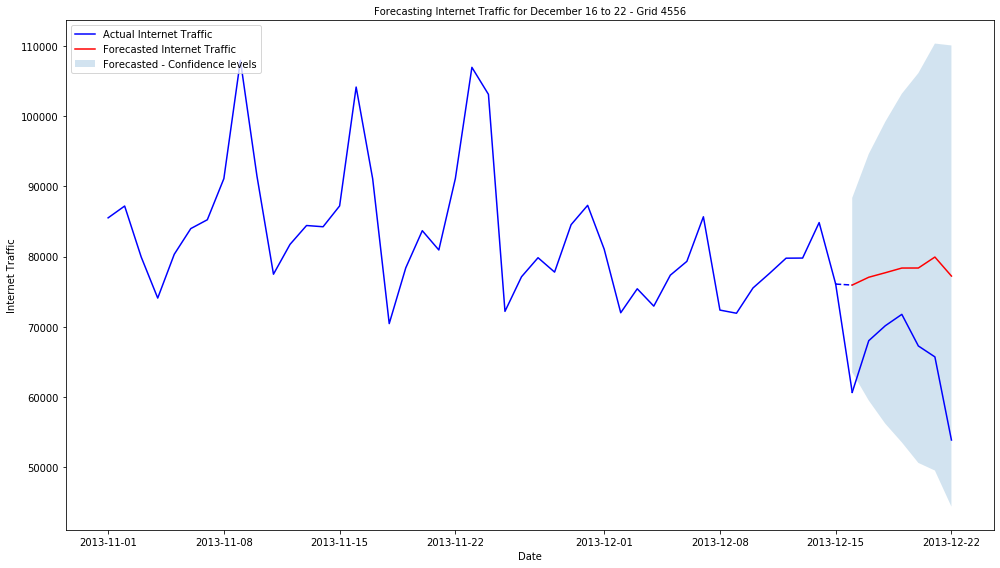

In [167]:
#Superposed time series plot

plt.figure(figsize=(14,8))
plt.plot(daily4556Internet_fort.index, daily4556Internet_fort, 'b', label='Actual Internet Traffic')
plt.plot(daily4556Internet_forte.index, daily4556Internet_forte, 'b')

# Plot the prediction means as line
plt.plot([daily4556Internet_fort.index[-1],mean.index[0]], [daily4556Internet_fort.values[-1],mean[0]], 'b--')
plt.plot([daily4556Internet_fort.index[-1],daily4556Internet_forte.index[0]], \
         [daily4556Internet_fort.values[-1],daily4556Internet_forte.values[0]], 'b')

plt.plot(mean.index, mean, label='Forecasted Internet Traffic', color='r')

plt.fill_between(mean.index, conf_int.iloc[:,0], conf_int.iloc[:,1], alpha=0.2, label='Forecasted - Confidence levels')
plt.legend(loc='upper left')
plt.title('Forecasting Internet Traffic for December 16 to 22 - Grid 4556')
plt.xlabel('Date')
plt.ylabel('Internet Traffic')
plt.tight_layout()
plt.savefig('sav_images/4556_internet_for.svg',transparent=True)
plt.show()
plt.show()

In [168]:
#Function to calculate MAE and MAPE
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [169]:
#Forcasting Error for the above grid
mae_error = mean_absolute_error(daily4556Internet_forte.internet,mean)
mape_error = mean_absolute_percentage_error(daily4556Internet_forte.internet,mean)
print("Mean Absolute Error (MAE) = {:.3f}".format(mae_error))
print("Mean Absolute Percentage Error (MAPE) = {:.3f}%".format(mape_error))
print("Accuracy = {:.3f}%".format(100-mape_error))

Mean Absolute Error (MAE) = 12445.145
Mean Absolute Percentage Error (MAPE) = 19.978%
Accuracy = 80.022%


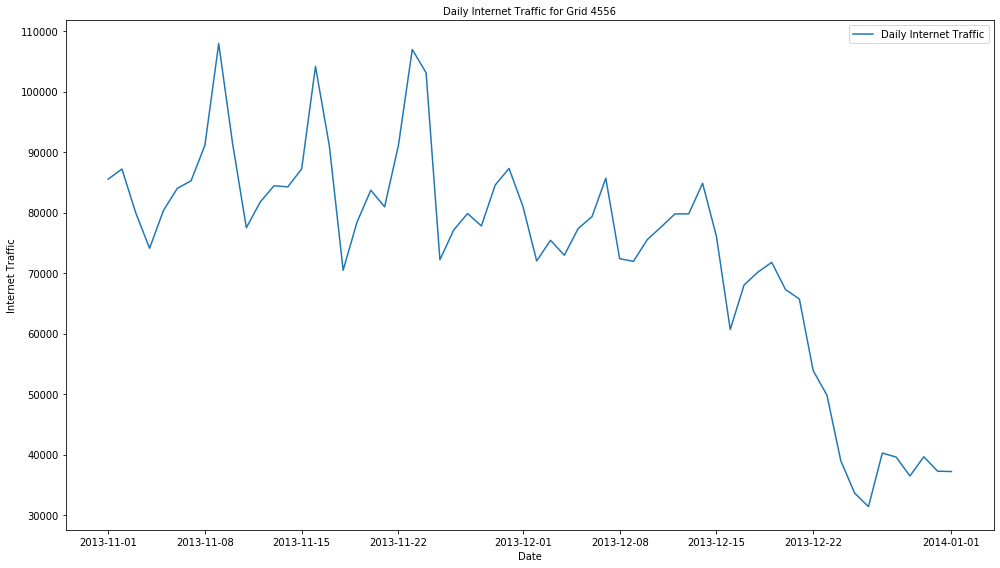

In [156]:
#Time series plot of grid 4556's Daily Internet Activity including December 16 to 22
plt.figure(figsize=(14,8))
plt.plot(daily4556Internet.index, daily4556Internet, label='Daily Internet Traffic')
plt.title('Daily Internet Traffic for Grid 4556')
plt.xlabel('Date')
plt.ylabel('Internet Traffic')
plt.legend()
plt.tight_layout()
plt.savefig('sav_images/4556_internet_daily_all.svg',transparent=True)
plt.show()

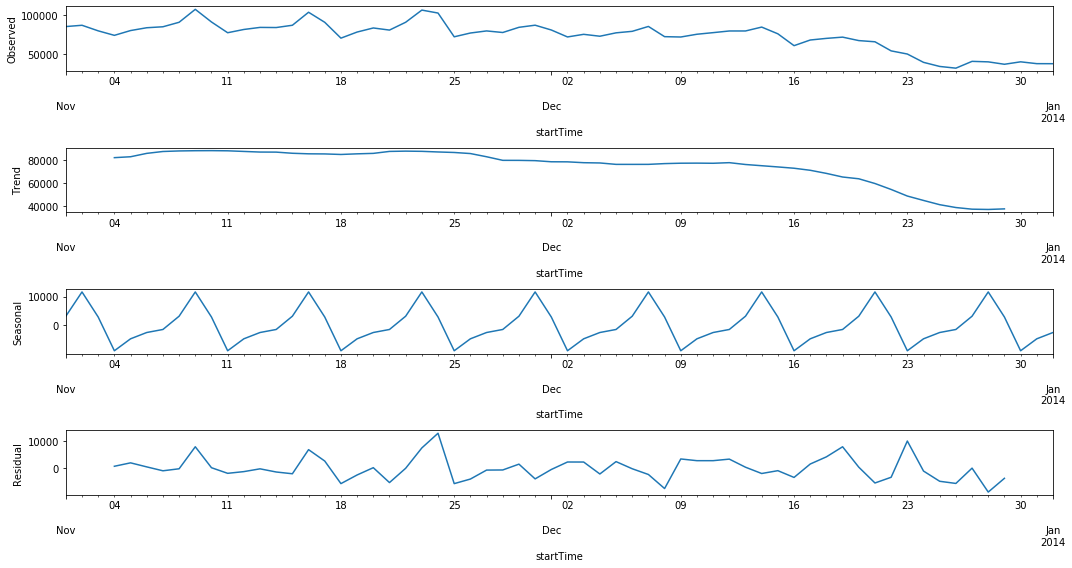

In [157]:
decomp_results = seasonal_decompose(daily4556Internet, period=7)

# Plot decomposed data
res = decomp_results
fig, axes = plt.subplots(4,1,figsize=(15,8))
res.observed.plot(ax=axes[0],legend=False)
axes[0].set_ylabel('Observed')
res.trend.plot(ax=axes[1],legend=False)
axes[1].set_ylabel('Trend')
res.seasonal.plot(ax=axes[2],legend=False)
axes[2].set_ylabel('Seasonal')
res.resid.plot(ax=axes[3],legend=False)
axes[3].set_ylabel('Residual')
plt.tight_layout()
plt.savefig('sav_images/4556_ts_decomp_all.svg',transparent=True)
plt.show()

### End of Grid 4556
### -------------------------